In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
from pyspark.sql.functions import col, sum as spark_sum

# === [0] 테이블 불러오기 ===
monthly_df = spark.table("postgres_team5_catalog.bronze.monthly_acid_stats")
age_df = spark.table("postgres_team5_catalog.tra.traffic_acid_stats_age")

# === [1] stat_type별로 pivot 후 prefix 붙여서 병합 ===
def pivot_by_stat_type(df, stat_type, group_cols, pivot_col, prefix):
    return (
        df.filter(col("stat_type") == stat_type)
          .groupBy(group_cols)
          .pivot(pivot_col)
          .agg(spark_sum("data"))
          .na.fill(0)
          .toDF(*(group_cols + [f"{prefix}_{col}" for col in df.filter(col("stat_type") == stat_type).select(pivot_col).distinct().rdd.flatMap(lambda x: x).collect()]))
    )

# === [2] 각 테이블에 대해 stat_type별 피벗 생성 ===
# 월별

monthly_death = pivot_by_stat_type(monthly_df, "사망자수 (명)", ["searchyear", "gugun_nm"], "searchmonth", "월_사망")
monthly_injury = pivot_by_stat_type(monthly_df, "부상자수 (명)", ["searchyear", "gugun_nm"], "searchmonth", "월_부상")
monthly_total = pivot_by_stat_type(monthly_df, "발생건수 (건)", ["searchyear", "gugun_nm"], "searchmonth", "월_발생")


# 연령대별
age_death = pivot_by_stat_type(age_df, "사망자수", ["searchyear", "gugun_nm"], "ages", "연령_사망")
age_injury = pivot_by_stat_type(age_df, "부상자수", ["searchyear", "gugun_nm"], "ages", "연령_부상")

# === [3] 전체 병합 ===
feature_df = monthly_death \
    .join(monthly_injury, ["searchyear", "gugun_nm"], "inner") \
    .join(monthly_total, ["searchyear", "gugun_nm"], "inner") \
    .join(age_death, ["searchyear", "gugun_nm"], "inner") \
    .join(age_injury, ["searchyear", "gugun_nm"], "inner") \
    .na.fill(0)


cols_to_drop = [col for col in feature_df.columns if "전체" in col]
feature_df = feature_df.drop(*cols_to_drop)
feature_df = feature_df.filter(feature_df["gugun_nm"] != "전체")


# 결과 미리 보기
display(feature_df)

searchyear,gugun_nm,월_사망_1,월_사망_9,월_사망_4,월_사망_8,월_사망_12,월_사망_6,월_사망_3,월_사망_10,월_사망_11,월_사망_2,월_사망_7,월_사망_5,월_부상_1,월_부상_9,월_부상_4,월_부상_8,월_부상_12,월_부상_6,월_부상_3,월_부상_10,월_부상_11,월_부상_2,월_부상_7,월_부상_5,월_발생_1,월_발생_9,월_발생_4,월_발생_8,월_발생_12,월_발생_6,월_발생_3,월_발생_10,월_발생_11,월_발생_2,월_발생_7,월_발생_5,연령_사망_13~20세,연령_사망_41~50세,연령_사망_21~30세,연령_사망_12세이하,연령_사망_불명,연령_사망_71세이상,연령_사망_51~60세,연령_사망_15~20세,연령_사망_65~70세,연령_사망_31~40세,연령_사망_14세 이하,연령_사망_61~64세,연령_부상_13~20세,연령_부상_41~50세,연령_부상_21~30세,연령_부상_12세이하,연령_부상_71세이상,연령_부상_불명,연령_부상_51~60세,연령_부상_15~20세,연령_부상_65~70세,연령_부상_31~40세,연령_부상_14세 이하,연령_부상_61~64세
2017,용산구,0,1,2,1,0,0,0,1,4,2,0,1,169,216,157,200,122,135,153,161,135,157,155,189,109,150,102,120,89,89,111,117,103,101,112,134,0,0,0,0,6,2,0,2,0,0,2,12,0,0,24,76,464,450,343,295,92,86,84,1949
2006,동대문구,2,2,3,1,1,1,2,3,0,3,5,2,169,208,202,203,171,191,202,204,219,226,212,208,119,149,140,137,124,139,149,156,160,160,164,151,0,0,0,0,3,5,4,4,0,1,8,25,0,0,90,169,531,516,554,343,77,77,58,2415
2014,중구,0,1,0,1,2,0,0,2,0,0,0,1,121,171,156,169,100,163,123,147,146,162,167,160,93,124,109,119,74,126,95,112,107,119,115,112,0,0,0,0,0,2,1,1,2,0,1,7,0,0,35,69,324,424,343,326,98,106,60,1785
2007,성북구,1,0,4,0,0,1,0,1,2,0,0,0,143,152,192,158,117,129,140,196,176,173,157,210,102,112,141,114,79,97,114,141,123,115,113,140,0,0,1,2,1,0,1,1,1,0,2,9,0,0,107,148,415,411,371,295,74,68,54,1943
2010,광진구,1,3,3,2,1,2,0,2,1,1,0,1,140,230,188,169,138,170,201,198,161,203,203,211,101,150,138,119,90,118,148,139,114,136,151,136,0,0,2,1,3,4,1,2,0,2,2,17,0,0,104,159,522,439,450,351,68,62,57,2212
2020,성동구,0,0,1,1,0,2,0,0,0,2,2,1,123,123,131,95,102,103,133,137,140,141,125,128,86,101,102,83,76,77,89,96,104,108,99,98,0,0,0,0,0,2,0,1,0,1,5,9,0,0,27,63,343,303,265,230,91,78,81,1481
2006,은평구,1,6,1,3,0,1,0,0,0,3,1,2,167,161,171,151,123,165,171,189,130,182,181,173,111,110,125,109,82,118,118,138,104,123,128,125,0,0,0,0,4,2,3,2,1,4,2,18,0,0,158,157,379,415,423,280,56,56,40,1964
2008,은평구,1,1,5,2,0,1,0,0,2,1,1,2,133,187,187,182,122,122,165,233,205,210,215,199,105,140,143,125,88,90,120,168,159,153,155,150,0,0,2,1,2,0,4,2,1,2,2,16,0,0,152,236,375,386,461,310,78,86,76,2160
2020,관악구,0,1,2,2,2,1,1,0,1,1,1,1,129,160,144,152,158,145,137,145,148,173,172,156,91,133,121,123,114,121,112,111,119,137,145,117,0,0,0,0,0,2,1,3,2,2,3,13,0,0,43,89,458,365,281,273,95,110,105,1819
2019,노원구,1,1,0,1,0,1,0,1,0,2,0,1,201,203,231,179,136,169,191,203,187,192,188,222,137,165,175,136,101,123,139,153,138,148,139,149,0,0,0,1,0,0,1,4,0,1,1,8,0,0,101,163,371,373,413,437,132,149,162,2302


In [0]:
from pyspark.sql.functions import col, sum as spark_sum, when
from functools import reduce

# 월별 발생 총합
monthly_total_cols = [c for c in feature_df.columns if c.startswith("월_발생_")]
feature_df = feature_df.withColumn("total_monthly_accidents",
    reduce(lambda a, b: a + b, [col(c) for c in monthly_total_cols])
)

# 사망률 = 총 사망자수 / 총 발생건수
monthly_death_cols = [c for c in feature_df.columns if c.startswith("월_사망_")]
feature_df = feature_df.withColumn("total_monthly_deaths",
    reduce(lambda a, b: a + b, [col(c) for c in monthly_death_cols])
)

feature_df = feature_df.withColumn("monthly_death_ratio",
    when(col("total_monthly_accidents") == 0, 0)
    .otherwise(col("total_monthly_deaths") / col("total_monthly_accidents"))
)

# 연령대 취약층 비율 (예: 고령자 65세 이상 비중)
elderly_cols = [c for c in feature_df.columns if c.startswith("연령_부상_") and ("65~70세" in c or "71세이상" in c)]
all_injury_cols = [c for c in feature_df.columns if c.startswith("연령_부상_") and "전체" not in c]

feature_df = feature_df.withColumn("elderly_injuries", reduce(lambda a, b: a + b, [col(c) for c in elderly_cols]))
feature_df = feature_df.withColumn("total_injuries_by_age", reduce(lambda a, b: a + b, [col(c) for c in all_injury_cols]))
feature_df = feature_df.withColumn("elderly_ratio",
    when(col("total_injuries_by_age") == 0, 0).otherwise(col("elderly_injuries") / col("total_injuries_by_age"))
)

display(feature_df)
feature_df.columns

searchyear,gugun_nm,월_사망_1,월_사망_9,월_사망_4,월_사망_8,월_사망_12,월_사망_6,월_사망_3,월_사망_10,월_사망_11,월_사망_2,월_사망_7,월_사망_5,월_부상_1,월_부상_9,월_부상_4,월_부상_8,월_부상_12,월_부상_6,월_부상_3,월_부상_10,월_부상_11,월_부상_2,월_부상_7,월_부상_5,월_발생_1,월_발생_9,월_발생_4,월_발생_8,월_발생_12,월_발생_6,월_발생_3,월_발생_10,월_발생_11,월_발생_2,월_발생_7,월_발생_5,연령_사망_13~20세,연령_사망_41~50세,연령_사망_21~30세,연령_사망_12세이하,연령_사망_불명,연령_사망_71세이상,연령_사망_51~60세,연령_사망_15~20세,연령_사망_65~70세,연령_사망_31~40세,연령_사망_14세 이하,연령_사망_61~64세,연령_부상_13~20세,연령_부상_41~50세,연령_부상_21~30세,연령_부상_12세이하,연령_부상_71세이상,연령_부상_불명,연령_부상_51~60세,연령_부상_15~20세,연령_부상_65~70세,연령_부상_31~40세,연령_부상_14세 이하,연령_부상_61~64세,total_monthly_accidents,total_monthly_deaths,monthly_death_ratio,elderly_injuries,total_injuries_by_age,elderly_ratio
2017,용산구,0,1,2,1,0,0,0,1,4,2,0,1,169,216,157,200,122,135,153,161,135,157,155,189,109,150,102,120,89,89,111,117,103,101,112,134,0,0,0,0,6,2,0,2,0,0,2,12,0,0,24,76,464,450,343,295,92,86,84,1949,1337,12,0.008975317875841436,556,3863,0.14392958840279577
2006,동대문구,2,2,3,1,1,1,2,3,0,3,5,2,169,208,202,203,171,191,202,204,219,226,212,208,119,149,140,137,124,139,149,156,160,160,164,151,0,0,0,0,3,5,4,4,0,1,8,25,0,0,90,169,531,516,554,343,77,77,58,2415,1748,25,0.014302059496567507,608,4830,0.125879917184265
2014,중구,0,1,0,1,2,0,0,2,0,0,0,1,121,171,156,169,100,163,123,147,146,162,167,160,93,124,109,119,74,126,95,112,107,119,115,112,0,0,0,0,0,2,1,1,2,0,1,7,0,0,35,69,324,424,343,326,98,106,60,1785,1305,7,0.0053639846743295016,422,3570,0.11820728291316526
2007,성북구,1,0,4,0,0,1,0,1,2,0,0,0,143,152,192,158,117,129,140,196,176,173,157,210,102,112,141,114,79,97,114,141,123,115,113,140,0,0,1,2,1,0,1,1,1,0,2,9,0,0,107,148,415,411,371,295,74,68,54,1943,1391,9,0.006470165348670022,489,3886,0.1258363355635615
2010,광진구,1,3,3,2,1,2,0,2,1,1,0,1,140,230,188,169,138,170,201,198,161,203,203,211,101,150,138,119,90,118,148,139,114,136,151,136,0,0,2,1,3,4,1,2,0,2,2,17,0,0,104,159,522,439,450,351,68,62,57,2212,1540,17,0.01103896103896104,590,4424,0.1333634719710669
2020,성동구,0,0,1,1,0,2,0,0,0,2,2,1,123,123,131,95,102,103,133,137,140,141,125,128,86,101,102,83,76,77,89,96,104,108,99,98,0,0,0,0,0,2,0,1,0,1,5,9,0,0,27,63,343,303,265,230,91,78,81,1481,1119,9,0.00804289544235925,434,2962,0.14652261985145174
2006,은평구,1,6,1,3,0,1,0,0,0,3,1,2,167,161,171,151,123,165,171,189,130,182,181,173,111,110,125,109,82,118,118,138,104,123,128,125,0,0,0,0,4,2,3,2,1,4,2,18,0,0,158,157,379,415,423,280,56,56,40,1964,1391,18,0.012940330697340043,435,3928,0.11074338085539714
2008,은평구,1,1,5,2,0,1,0,0,2,1,1,2,133,187,187,182,122,122,165,233,205,210,215,199,105,140,143,125,88,90,120,168,159,153,155,150,0,0,2,1,2,0,4,2,1,2,2,16,0,0,152,236,375,386,461,310,78,86,76,2160,1596,16,0.010025062656641603,453,4320,0.10486111111111111
2020,관악구,0,1,2,2,2,1,1,0,1,1,1,1,129,160,144,152,158,145,137,145,148,173,172,156,91,133,121,123,114,121,112,111,119,137,145,117,0,0,0,0,0,2,1,3,2,2,3,13,0,0,43,89,458,365,281,273,95,110,105,1819,1444,13,0.009002770083102494,553,3638,0.1520065970313359
2019,노원구,1,1,0,1,0,1,0,1,0,2,0,1,201,203,231,179,136,169,191,203,187,192,188,222,137,165,175,136,101,123,139,153,138,148,139,149,0,0,0,1,0,0,1,4,0,1,1,8,0,0,101,163,371,373,413,437,132,149,162,2302,1703,8,0.004697592483852026,503,4603,0.10927655876602216


['searchyear',
 'gugun_nm',
 '월_사망_1',
 '월_사망_9',
 '월_사망_4',
 '월_사망_8',
 '월_사망_12',
 '월_사망_6',
 '월_사망_3',
 '월_사망_10',
 '월_사망_11',
 '월_사망_2',
 '월_사망_7',
 '월_사망_5',
 '월_부상_1',
 '월_부상_9',
 '월_부상_4',
 '월_부상_8',
 '월_부상_12',
 '월_부상_6',
 '월_부상_3',
 '월_부상_10',
 '월_부상_11',
 '월_부상_2',
 '월_부상_7',
 '월_부상_5',
 '월_발생_1',
 '월_발생_9',
 '월_발생_4',
 '월_발생_8',
 '월_발생_12',
 '월_발생_6',
 '월_발생_3',
 '월_발생_10',
 '월_발생_11',
 '월_발생_2',
 '월_발생_7',
 '월_발생_5',
 '연령_사망_13~20세',
 '연령_사망_41~50세',
 '연령_사망_21~30세',
 '연령_사망_12세이하',
 '연령_사망_불명',
 '연령_사망_71세이상',
 '연령_사망_51~60세',
 '연령_사망_15~20세',
 '연령_사망_65~70세',
 '연령_사망_31~40세',
 '연령_사망_14세 이하',
 '연령_사망_61~64세',
 '연령_부상_13~20세',
 '연령_부상_41~50세',
 '연령_부상_21~30세',
 '연령_부상_12세이하',
 '연령_부상_71세이상',
 '연령_부상_불명',
 '연령_부상_51~60세',
 '연령_부상_15~20세',
 '연령_부상_65~70세',
 '연령_부상_31~40세',
 '연령_부상_14세 이하',
 '연령_부상_61~64세',
 'total_monthly_accidents',
 'total_monthly_deaths',
 'monthly_death_ratio',
 'elderly_injuries',
 'total_injuries_by_age',
 'elderly_ratio']

In [0]:
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

# 1. 사고 심각도 등급 파생 컬럼 생성
feature_df = feature_df.withColumn("severity_level",
    when(col("monthly_death_ratio") < 0.01, "Low")
    .when(col("monthly_death_ratio") < 0.03, "Medium")
    .otherwise("High")
)

# 2. feature 컬럼 추출
exclude_cols = {"searchyear", "gugun_nm", "severity_level", "total_monthly_deaths"}  # 필요시 조정
feature_cols = [c for c in feature_df.columns if c not in exclude_cols]

# 3. feature vector 생성
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# 4. target label 인코딩 # 'severity_level' 컬럼이 "Low", "Medium", "High"일 경우 0, 1, 2로 변환
label_indexer = StringIndexer(inputCol="severity_level", outputCol="label")

# 5. 분류 모델 정의 (랜덤 포레스트)
rf_cls  = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100)

# 6. 파이프라인 구성
pipeline = Pipeline(stages=[assembler, label_indexer, rf_cls])

# 7. 모델 훈련
train_df, test_df = feature_df.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train_df)

# 8. 예측 결과 생성
predictions_cls = model.transform(test_df)

# 9. 예측 결과 확인 -> 사고 심각도 등급 파생 컬럼
label_col = "label"
prediction_col = "prediction"

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# 정확도
evaluator_acc = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol=prediction_col, metricName="accuracy")
accuracy = evaluator_acc.evaluate(predictions_cls)

# 정밀도
evaluator_precision = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol=prediction_col, metricName="weightedPrecision")
precision = evaluator_precision.evaluate(predictions_cls)

# 재현율
evaluator_recall = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol=prediction_col, metricName="weightedRecall")
recall = evaluator_recall.evaluate(predictions_cls)

# F1 점수
evaluator_f1 = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol=prediction_col, metricName="f1")
f1_score = evaluator_f1.evaluate(predictions_cls)

print(f"RandomForestClassifier - Accuracy:  {accuracy:.4f}")
print(f"RandomForestClassifier - Precision: {precision:.4f}")
print(f"RandomForestClassifier - Recall:    {recall:.4f}")
print(f"RandomForestClassifier - F1 Score:  {f1_score:.4f}")

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

RandomForestClassifier - Accuracy:  0.9865
RandomForestClassifier - Precision: 0.9869
RandomForestClassifier - Recall:    0.9865
RandomForestClassifier - F1 Score:  0.9865


In [0]:
from pyspark.ml.regression import RandomForestRegressor

label_col = "total_monthly_deaths"
rf_reg = RandomForestRegressor(labelCol=label_col, featuresCol="features", numTrees=100)
pipeline_reg = Pipeline(stages=[assembler, rf_reg])

# 훈련 및 예측
model_reg = pipeline_reg.fit(train_df)
predictions_reg = model_reg.transform(test_df)

# 평가
from pyspark.ml.evaluation import RegressionEvaluator
label_col = "total_monthly_deaths"

evaluator_rmse = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol=label_col, predictionCol="prediction", metricName="r2")
rmse = evaluator_rmse.evaluate(predictions_reg)
mae = evaluator_mae.evaluate(predictions_reg)
r2 = evaluator_r2.evaluate(predictions_reg)
print(f"RandomForestRegressor - RMSE: {rmse:.4f}")
print(f"RandomForestRegressor - MAE:  {mae:.4f}")
print(f"RandomForestRegressor - R²:   {r2:.4f}")

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

RandomForestRegressor - RMSE: 1.0399
RandomForestRegressor - MAE:  0.5872
RandomForestRegressor - R²:   0.9782


/root/.ipykernel/881/command-7131791363570357-2327788058:30: UserWarning: Glyph 54924 (\N{HANGUL SYLLABLE HOE}) missing from current font.
  plt.tight_layout()
/root/.ipykernel/881/command-7131791363570357-2327788058:30: UserWarning: Glyph 44480 (\N{HANGUL SYLLABLE GWI}) missing from current font.
  plt.tight_layout()
/databricks/python/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54924 (\N{HANGUL SYLLABLE HOE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/databricks/python/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44480 (\N{HANGUL SYLLABLE GWI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


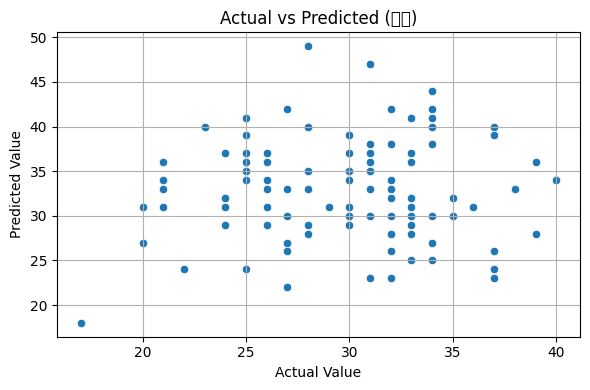

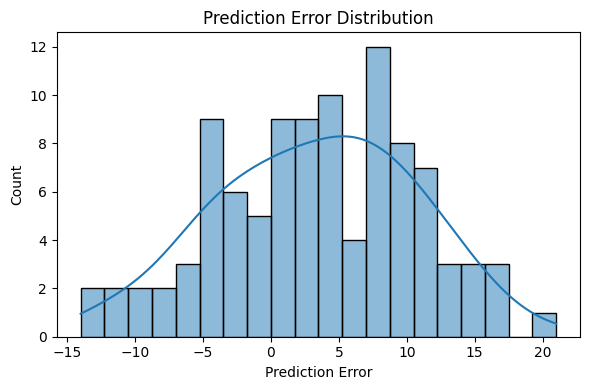

/root/.ipykernel/881/command-7131791363570357-2327788058:47: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from current font.
  plt.tight_layout()
/root/.ipykernel/881/command-7131791363570357-2327788058:47: UserWarning: Glyph 45224 (\N{HANGUL SYLLABLE NAM}) missing from current font.
  plt.tight_layout()
/root/.ipykernel/881/command-7131791363570357-2327788058:47: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from current font.
  plt.tight_layout()
/root/.ipykernel/881/command-7131791363570357-2327788058:47: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from current font.
  plt.tight_layout()
/root/.ipykernel/881/command-7131791363570357-2327788058:47: UserWarning: Glyph 48513 (\N{HANGUL SYLLABLE BUG}) missing from current font.
  plt.tight_layout()
/root/.ipykernel/881/command-7131791363570357-2327788058:47: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from current font.
  plt.tight_layout()
/root/.ipykernel/881/command-7131791363

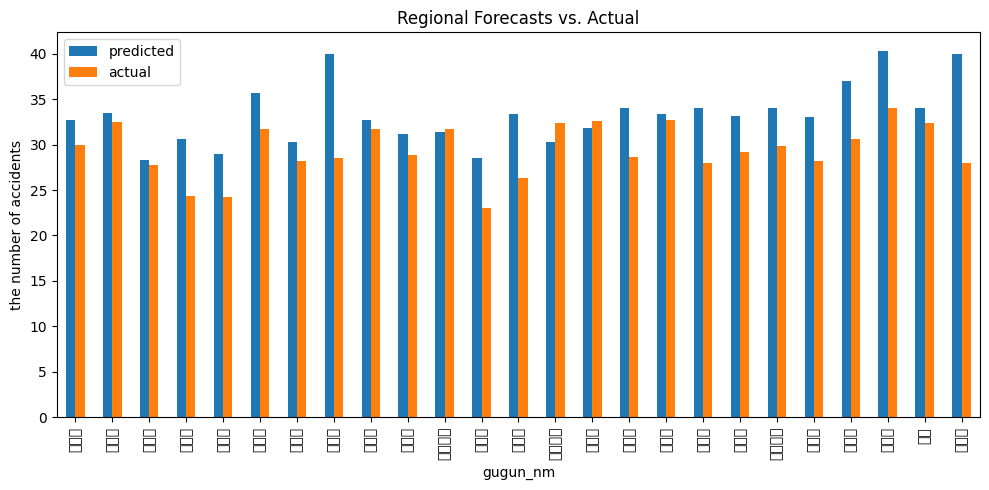

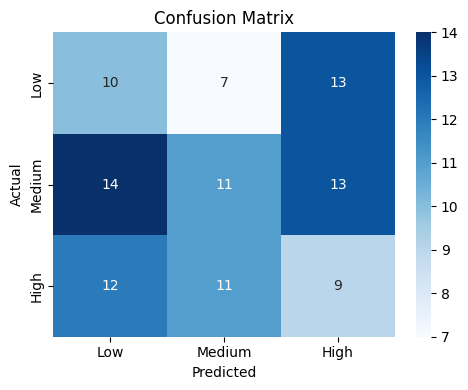

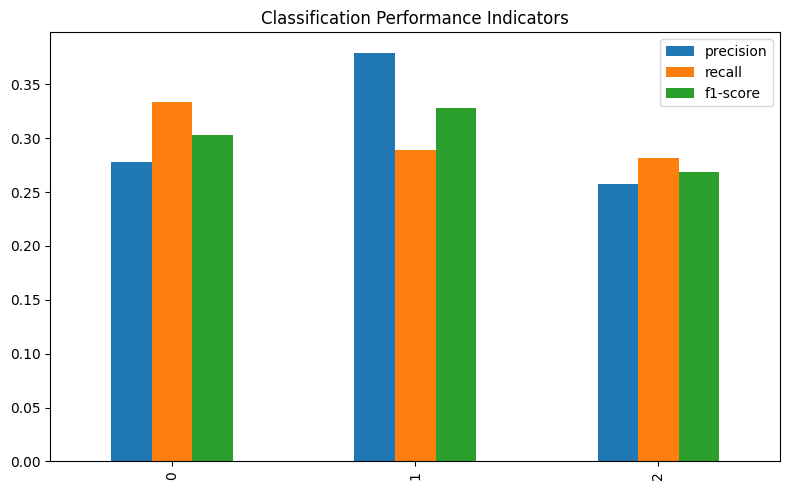

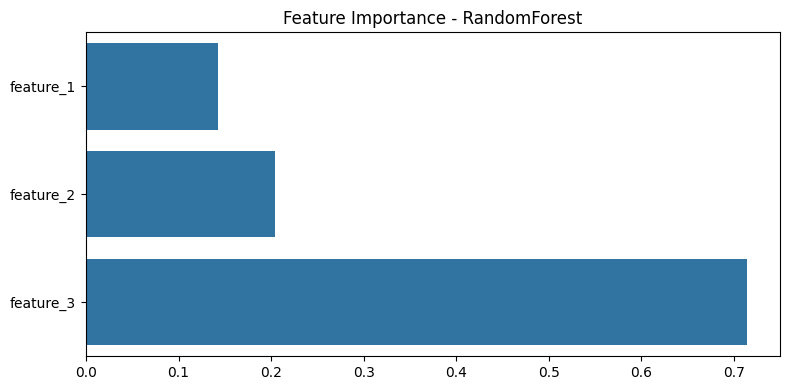

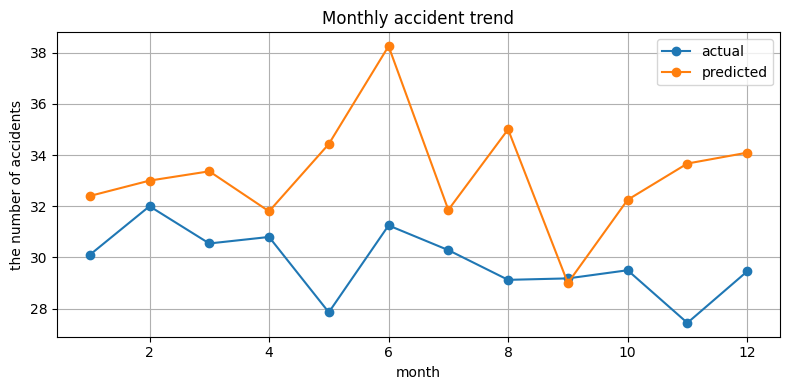

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.font_manager as fm


# 샘플 데이터 생성
np.random.seed(42)
guguns = feature_df.select("gugun_nm").distinct().rdd.flatMap(lambda x: x).collect()
df = pd.DataFrame({
    "gugun_nm": np.random.choice(guguns, size=100),
    "month": np.random.randint(1, 13, size=100),
    "actual": np.random.poisson(30, 100),
    "predicted": np.random.poisson(32, 100),
    "label": np.random.choice([0, 1, 2], size=100),  # 실제 등급
    "prediction_cls": np.random.choice([0, 1, 2], size=100)  # 분류 결과
})
feature_cols = ["feature_1", "feature_2", "feature_3"]
importances = np.random.rand(3)

# 1. 회귀 산점도
plt.figure(figsize=(6, 4))
sns.scatterplot(x=df["actual"], y=df["predicted"])
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.title("Actual vs Predicted (회귀)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. 오차 분포
errors = df["predicted"] - df["actual"]
plt.figure(figsize=(6, 4))
sns.histplot(errors, bins=20, kde=True)
plt.title("Prediction Error Distribution")
plt.xlabel("Prediction Error")
plt.tight_layout()
plt.show()

# 3. 지역별 예측 vs 실제
grouped = df.groupby("gugun_nm")[["predicted", "actual"]].mean().reset_index()
grouped.plot(x="gugun_nm", kind="bar", figsize=(10, 5))
plt.title("Regional Forecasts vs. Actual")
plt.ylabel("the number of accidents")
plt.tight_layout()
plt.show()

# 4. Confusion Matrix
class_labels = ["Low", "Medium", "High"]
cm = confusion_matrix(df["label"], df["prediction_cls"])
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# 5. 분류 성능 지표
report = classification_report(df["label"], df["prediction_cls"], output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report[["precision", "recall", "f1-score"]].iloc[:3].plot(kind='bar', figsize=(8, 5))
plt.title("Classification Performance Indicators")
plt.tight_layout()
plt.show()

# 6. Feature Importance
plt.figure(figsize=(8, 4))
sns.barplot(x=importances, y=feature_cols)
plt.title("Feature Importance - RandomForest")
plt.tight_layout()
plt.show()

# 7. 월별 사고 추이
df.groupby("month")[["actual", "predicted"]].mean().plot(figsize=(8,4), marker='o')
plt.title("Monthly accident trend")
plt.ylabel("the number of accidents")
plt.grid(True)
plt.tight_layout()
plt.show()


In [0]:
predictions_reg = predictions_reg.withColumnRenamed("prediction", "reg_prediction")

predictions_cls = predictions_cls.withColumnRenamed("prediction", "cls_prediction")

common_columns = set(predictions_reg.columns).intersection(predictions_cls.columns)
common_columns -= set(["searchyear", "gugun_nm"])  # join 키 제외
predictions_cls_trimmed = predictions_cls.drop(*common_columns)

joined_df = predictions_reg.join(predictions_cls_trimmed, on=["searchyear", "gugun_nm"], how="inner")

for col_name in joined_df.columns:
    new_name = col_name.replace(" ", "_")  # 또는 .replace(" ", "")로 완전 제거
    joined_df = joined_df.withColumnRenamed(col_name, new_name)

# 불필요한 컬럼 삭제
cols_to_drop = ["features", "rawPrediction", "probability"]
clean_df = joined_df.drop(*cols_to_drop)


display(clean_df)


from pyspark.sql.functions import col, count, isnan

# null이 있는 컬럼 찾기
null_cols = [c for c in clean_df.columns if clean_df.filter(col(c).isNull()).count() > 0]

# null → 0
clean_df = clean_df.fillna(0, subset=null_cols)


clean_df.write.format("delta").mode("overwrite").saveAsTable("1dt_team5_databricks_traffic.gold_managed.gold_months_ages_acid")


searchyear,gugun_nm,월_사망_1,월_사망_9,월_사망_4,월_사망_8,월_사망_12,월_사망_6,월_사망_3,월_사망_10,월_사망_11,월_사망_2,월_사망_7,월_사망_5,월_부상_1,월_부상_9,월_부상_4,월_부상_8,월_부상_12,월_부상_6,월_부상_3,월_부상_10,월_부상_11,월_부상_2,월_부상_7,월_부상_5,월_발생_1,월_발생_9,월_발생_4,월_발생_8,월_발생_12,월_발생_6,월_발생_3,월_발생_10,월_발생_11,월_발생_2,월_발생_7,월_발생_5,연령_사망_13~20세,연령_사망_41~50세,연령_사망_21~30세,연령_사망_12세이하,연령_사망_불명,연령_사망_71세이상,연령_사망_51~60세,연령_사망_15~20세,연령_사망_65~70세,연령_사망_31~40세,연령_사망_14세_이하,연령_사망_61~64세,연령_부상_13~20세,연령_부상_41~50세,연령_부상_21~30세,연령_부상_12세이하,연령_부상_71세이상,연령_부상_불명,연령_부상_51~60세,연령_부상_15~20세,연령_부상_65~70세,연령_부상_31~40세,연령_부상_14세_이하,연령_부상_61~64세,total_monthly_accidents,total_monthly_deaths,monthly_death_ratio,elderly_injuries,total_injuries_by_age,elderly_ratio,severity_level,reg_prediction,label,cls_prediction
2005,강북구,0,1,0,3,1,3,1,3,3,0,1,2,142,137,150,164,98,119,140,120,113,125,132,166,88,100,113,112,71,91,92,82,76,101,92,118,0,0,2,1,1,2,3,6,0,0,3,18,0,0,113,108,319,353,384,208,55,43,23,1606,1136,18,0.01584507042253521,374,3212,0.11643835616438356,Medium,17.659173969124282,1.0,1.0
2005,구로구,2,2,2,3,0,0,5,1,2,1,4,2,143,204,221,264,132,152,147,149,179,203,219,183,89,110,120,159,76,103,101,114,113,131,146,125,0,0,0,1,3,5,3,2,3,2,5,24,0,0,127,185,504,471,481,253,84,54,37,2196,1387,24,0.017303532804614274,588,4392,0.13387978142076504,Medium,23.572778017604335,1.0,1.0
2005,노원구,1,0,4,2,2,2,1,1,2,1,4,0,249,198,217,268,183,269,237,242,211,179,205,180,137,131,153,175,114,169,154,154,148,110,143,134,0,0,0,1,1,2,4,1,1,2,8,20,0,0,210,172,510,566,668,314,84,63,51,2638,1722,20,0.011614401858304297,594,5276,0.11258529188779379,Medium,20.545539910330312,1.0,1.0
2005,서대문구,2,2,1,3,1,0,0,1,4,0,0,2,113,145,122,167,116,116,141,124,133,122,130,160,79,84,87,102,65,82,90,94,97,84,86,99,0,0,1,2,2,2,1,1,2,2,3,16,0,0,93,80,367,385,356,193,52,34,29,1589,1049,16,0.015252621544327931,419,3178,0.131843926998112,Medium,15.352464586449377,1.0,1.0
2005,영등포구,2,1,4,2,5,0,2,5,2,2,3,4,271,326,303,322,170,201,334,282,268,257,291,256,168,207,198,224,117,146,220,182,186,162,193,183,0,0,2,1,2,9,4,5,1,3,5,32,0,0,143,184,746,813,755,442,93,58,47,3281,2186,32,0.01463860933211345,839,6562,0.12785736056080463,Medium,30.76828259228931,1.0,1.0
2005,중구,1,0,1,1,1,1,0,1,2,2,3,0,156,173,149,196,119,137,150,189,136,165,148,139,97,122,106,143,87,100,108,131,97,119,113,110,0,0,0,2,3,0,1,4,0,1,2,13,0,0,32,66,484,462,431,230,74,43,35,1857,1333,13,0.009752438109527382,558,3714,0.15024232633279483,Low,13.22350924928724,0.0,1.0
2006,관악구,0,0,0,1,0,2,1,1,3,2,1,1,164,207,193,202,150,173,188,215,215,193,251,225,114,137,144,148,112,133,134,148,141,136,166,156,0,0,0,1,4,1,1,1,0,3,1,12,0,0,136,205,557,511,494,297,69,65,42,2376,1669,12,0.007189934092270821,626,4752,0.13173400673400673,Low,12.169983942496309,0.0,0.0
2006,동대문구,2,2,3,1,1,1,2,3,0,3,5,2,169,208,202,203,171,191,202,204,219,226,212,208,119,149,140,137,124,139,149,156,160,160,164,151,0,0,0,0,3,5,4,4,0,1,8,25,0,0,90,169,531,516,554,343,77,77,58,2415,1748,25,0.014302059496567507,608,4830,0.125879917184265,Medium,24.31623339374648,1.0,1.0
2006,용산구,1,0,2,1,0,0,1,3,1,0,3,2,140,162,163,175,150,152,189,207,146,182,202,166,79,111,117,109,102,101,117,132,97,119,128,117,0,0,0,0,3,4,3,1,1,1,1,14,0,0,64,71,523,520,435,274,68,59,20,2034,1329,14,0.010534236267870579,591,4068,0.14528023598820058,Medium,14.201924569576384,1.0,1.0
2006,은평구,1,6,1,3,0,1,0,0,0,3,1,2,167,161,171,151,123,165,171,189,130,182,181,173,111,110,125,109,82,118,118,138,104,123,128,125,0,0,0,0,4,2,3,2,1,4,2,18,0,0,158,157,379,415,423,280,56,56,40,1964,1391,18,0.012940330697340043,435,3928,0.11074338085539714,Medium,17.72037961439517,1.0,1.0


searchyear,gugun_nm,month,accidents,month_num,date
2005,강북구,월_발생_1,88,1,2005-01-01T00:00:00Z
2005,구로구,월_발생_1,89,1,2005-01-01T00:00:00Z
2005,노원구,월_발생_1,137,1,2005-01-01T00:00:00Z
2005,서대문구,월_발생_1,79,1,2005-01-01T00:00:00Z
2005,영등포구,월_발생_1,168,1,2005-01-01T00:00:00Z
2005,중구,월_발생_1,97,1,2005-01-01T00:00:00Z
2006,관악구,월_발생_1,114,1,2006-01-01T00:00:00Z
2006,동대문구,월_발생_1,119,1,2006-01-01T00:00:00Z
2006,용산구,월_발생_1,79,1,2006-01-01T00:00:00Z
2006,은평구,월_발생_1,111,1,2006-01-01T00:00:00Z


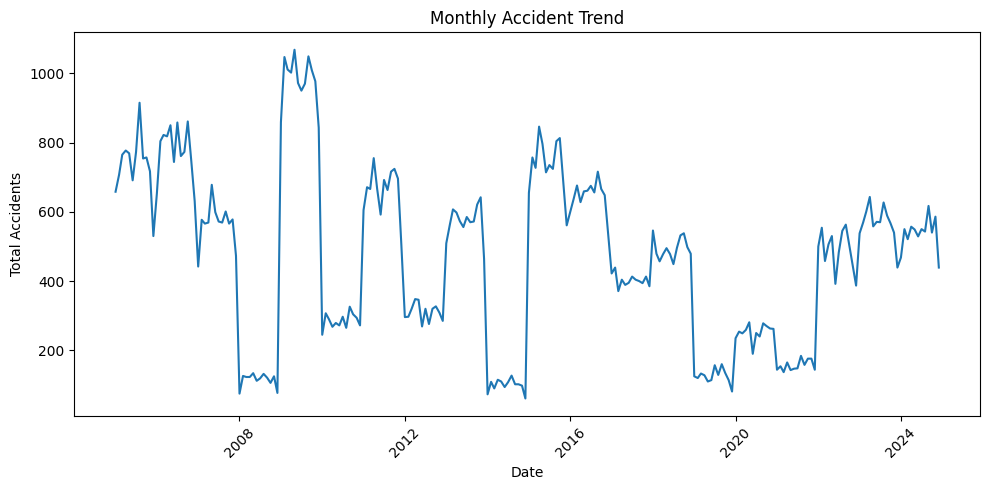

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

pdf = clean_df.toPandas()

# ——— 월별 추이 ———
# 월별 발생 건수 컬럼 리스트
monthly_cols = [c for c in pdf.columns if c.startswith('월_발생_')]
# Melt to long form
monthly_melt = pdf.melt(
    id_vars=['searchyear', 'gugun_nm'],
    value_vars=monthly_cols,
    var_name='month',
    value_name='accidents'
)
# 숫자로 된 월 정보 추출
monthly_melt['month_num'] = monthly_melt['month'].str.extract(r'월_발생_(\d+)').astype(int)
# 날짜 컬럼 생성
monthly_melt['date'] = pd.to_datetime(
    monthly_melt['searchyear'].astype(str) + '-' +
    monthly_melt['month_num'].astype(str).str.zfill(2) + '-01'
)
# 전체 구 합산
monthly_trend = monthly_melt.groupby('date')['accidents'].sum().reset_index()

display(monthly_melt)
